In [163]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
from lwa_f import snap2_fengine
from lwa_f import blocks
#from lwautils import lwa_arx 
import pandas as pd
from cr_functions import *
import struct
import math
from scipy import special as sp
from scipy import optimize as oz
from scipy import stats as st
from lwa_antpos import mapping
import os



## Connect to SNAP2 boards

In [165]:
brdnames=['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']
casperbrds = [casperfpga.CasperFpga(brdname, transport=casperfpga.TapcpTransport) for brdname in brdnames]
fpgfile='/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c.fpg'


## Set up ethernet and send a test snapshot

In [166]:
computer='gpu09' # 'lwacr' or 'gpu09'
packetwait=100 #clock cycles between packets
wait_after_readout=200 #time [clock cycles] to wait for other boards to finish readout
for i,brdname in enumerate(brdnames):
    casperbrd=casperbrds[i]
    #prepare to send a snapshot
    
    setup_data_source(casperbrd,"adc") #set the data source to ADC
    setup_ethernet(brdname,casperbrd,fpgfile,computer,packetwait) #set up the ethernet packetizer and ethernet block
    setvalue(casperbrd,'wait_after_readout','cr_registers.xlsx',wait_after_readout) #set the wait time after readout before new internally-generated triggers are accepted
    setvalue(casperbrd,'brd_id','cr_registers.xlsx',int(brdname[-2:])) #set the board id
    setvalue(casperbrd,'eth_enable','cr_registers.xlsx',1)  #enable ethernet

Data source set to adc
------------------------
snap01:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:01:01:01
Gateway:  0.0.0.1
IP:  10.41.0.201
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 25: MAC: 04:3F:72:DF:C1:F0
Setting wait between packets to 100
Data source set to adc
------------------------
snap02:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:02:02:02
Gateway:  0.0.0.1
IP:  10.41.0.202
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 25: MAC: 04:3F:72:DF:C1:F0
Setting wait between packets to 100
Data source set to adc
------------------------
snap03:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:03:03:03
Gateway:  0.0.0.1
IP:  10.41.0.203
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips:

In [167]:
[setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0) for casperbrd in casperbrds]


[None, None, None, None, None, None, None, None, None, None, None]

In [168]:
[setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0) for casperbrd in casperbrds]

#send trigger to just one board and all will send packets
software_trigger(casperbrds[3],1)

Packetizer formed 64 packets
Board successfully returned to listening state after readout
Readout took 137669 clock cycles
Packetizer never overflowed
Ethernet block almost-full counter incremented by 0


In [33]:

[setvalue(casperbrd,'eth_enable','cr_registers.xlsx',0)  for casperbrd in casperbrds]

[None, None, None, None, None, None, None, None, None, None, None]

In [156]:
current_ok_vetos=np.load('/home/ubuntu/kp/ok_vetos-2023-6-20.npy')
current_ok_core=np.load('/home/ubuntu/kp/ok_core-2023-6-20.npy')
ok_snaps=[0,0,2,3,4,5,6,7,8,9,10,] #zero indexed
for b in ok_snaps:
    casperbrd=casperbrds[b]
    veto_roles_array=current_ok_vetos[b,:]
    core_roles_array=current_ok_core[b,:]
    print(np.sum(veto_roles_array),np.sum(core_roles_array))

0 54
0 54
8 47
5 54
7 55
6 56
6 41
8 53
8 52
8 55
7 50


## Run Trigger 

In [187]:
%%capture output

[setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0) for casperbrd in casperbrds]


current_ok_vetos=np.load('/home/ubuntu/kp/ok_vetos-2023-6-30.npy')
current_ok_core=np.load('/home/ubuntu/kp/ok_core-2023-6-30.npy')
ok_snaps=[2,3,4,5,6,7,8,9,10] #zero indexed

#set up coincidencer
trigger_power_thresh=300**2
veto_power_thresh=250**2
trigger_window=int(round(1.96e8*100/3e8,1)) #number of clock cycles to travel 100 meters
veto_window=int(round(1.96e8*2000/3e8,1)) #number of clock cycles to travel 2000 meters
antenna_number_thresh=6 
veto_number_thresh=1

bufferwait=2000

for b in ok_snaps:
    casperbrd=casperbrds[b]
    veto_roles_array=current_ok_vetos[b,:]
    core_roles_array=current_ok_core[b,:]

    
    setup_coincidencer(casperbrd,trigger_power_thresh,
                          veto_power_thresh,
                          trigger_window,
                          veto_window,
                          antenna_number_thresh,
                          veto_number_thresh,
                          core_roles_array,
                          veto_roles_array)
    setvalue(casperbrd,"delay_trigger","cr_registers.xlsx",bufferwait)

    setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",1)






now=time.time()
duration=8*60*60 #run for 8 hours
#duration=20
finish=now+duration
waittime=10

#snapshots_per_second=np.zeros((11,int(duration/waittime)))
core_triggers=np.zeros((11,int(duration/waittime)))
veto_triggers=np.zeros((11,int(duration/waittime)))
snapshots_per_second=np.zeros((11,int(duration/waittime)))
otherstats1=np.zeros((11,int(duration/waittime)))
otherstats2=np.zeros((11,int(duration/waittime)))
otherstats3=np.zeros((11,int(duration/waittime)))
otherstats4=np.zeros((11,int(duration/waittime)))


i=0
#while time.time()<finish:
#    for b in ok_snaps:
#        casperbrd=casperbrds[b]
#        old_packets=getvalue(casperbrd,"eof_and_valid","cr_registers.xlsx")
#        time.sleep(2.75)  #wait to update
#         
#        current_packets=getvalue(casperbrd,"eof_and_valid","cr_registers.xlsx")
#        veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
#        new_packets=current_packets-old_packets
#        latest_snapshots_per_second=new_packets/(64*2.75)
#        snapshots_per_second[b,i]=latest_snapshots_per_second
#        core_triggers[b,i]=core_coincidence            
#        veto_triggers[b,i]=veto_coincidence
#        time.sleep(waittime)
#    i+=1

old_packets=[getvalue(casperbrd,"eof_and_valid","cr_registers.xlsx") for casperbrd in casperbrds]
time.sleep(waittime)
while time.time()<finish:
    current_packets=np.asarray([getvalue(casperbrd,"eof_and_valid","cr_registers.xlsx") for casperbrd in casperbrds])
    for b in ok_snaps:
        casperbrd=casperbrds[b]
        core_coincidence,veto_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
        otherstat1,otherstat2=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_n_veto_tot_clk_cycles1",2*4,0))
        otherstat3,otherstat4=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_n_veto_tot_clk_cycles",2*4,0))
        core_triggers[b,i]=core_coincidence            
        veto_triggers[b,i]=veto_coincidence
        otherstats1[b,i]=otherstat1
        otherstats2[b,i]=otherstat2
        otherstats3[b,i]=otherstat3
        otherstats4[b,i]=otherstat4

        packets=getvalue(casperbrd,"eof_and_valid","cr_registers.xlsx")
        #snapshots_per_second[b,i]=(packets - old_packets[b])/waittime
        #old_packets[b]=packets
    time.sleep(waittime)
    i+=1
                                                                             
                                                                             


[setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0) for casperbrd in casperbrds]


In [188]:
output.show()

[None, None, None, None, None, None, None, None, None, None, None]

In [194]:
fname_prefix='/home/ubuntu/kp/data/2023July1/rates'

#np.save(fname_prefix+'snapshots_from_packetizer',np.asarray(snapshots_per_second))
np.save(fname_prefix+'core',np.asarray(core_triggers))
np.save(fname_prefix+'veto',np.asarray(veto_triggers))
np.save(fname_prefix+'internaltrigger',np.asarray(otherstats1))
np.save(fname_prefix+'readoutdone',np.asarray(otherstats2))


In [195]:
print(i)

2765


In [196]:
int(duration/waittime)

2880

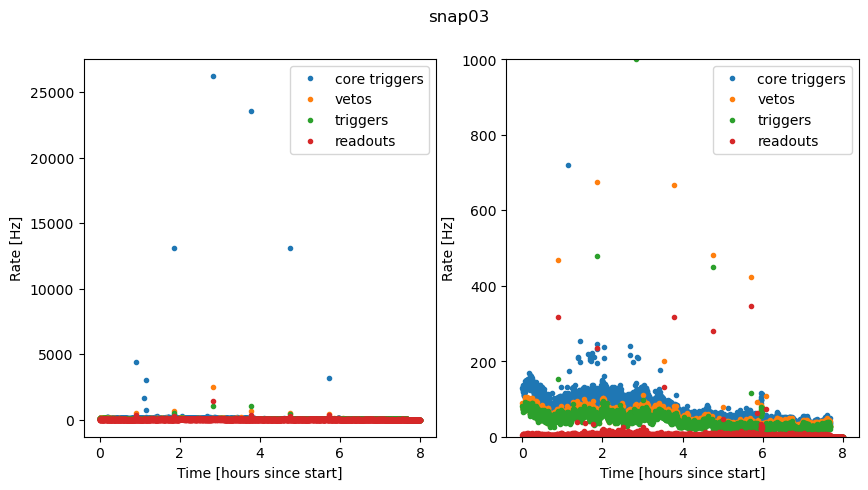

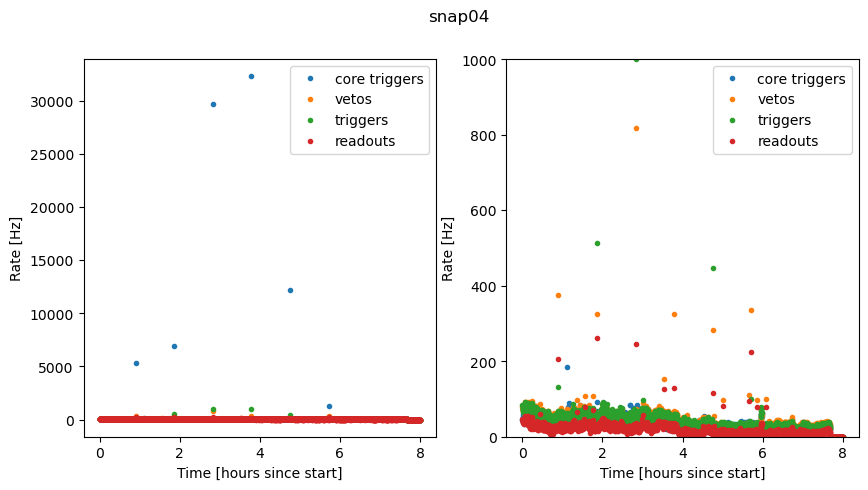

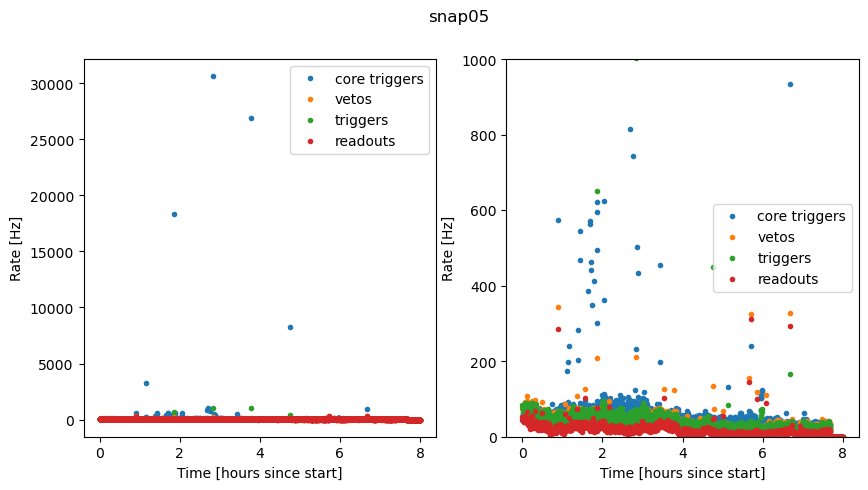

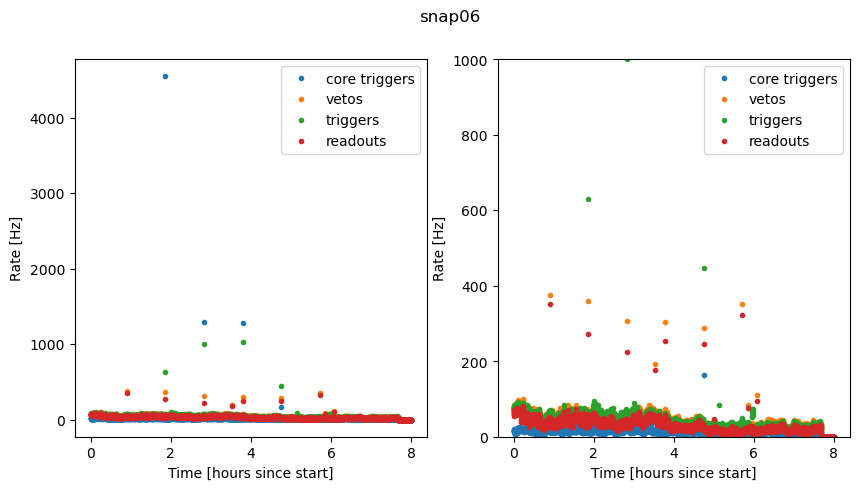

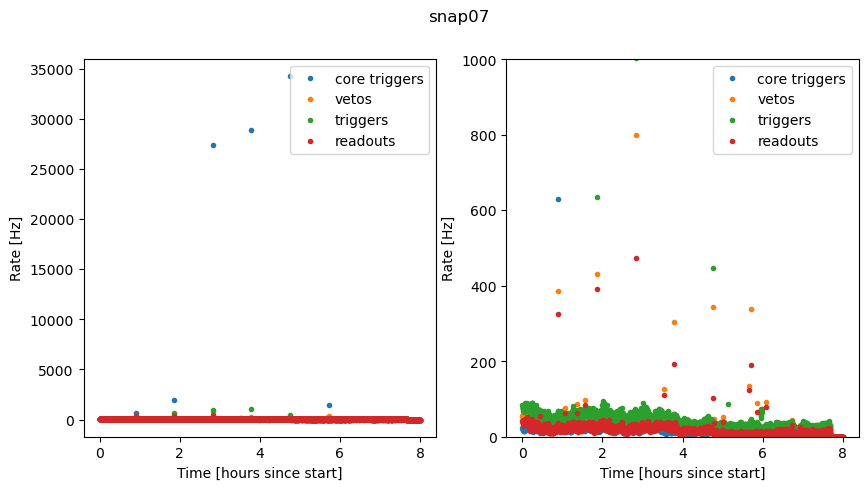

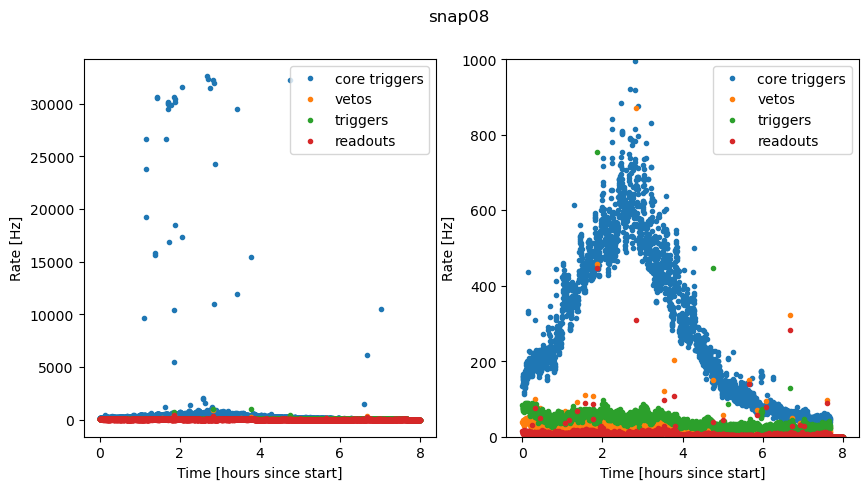

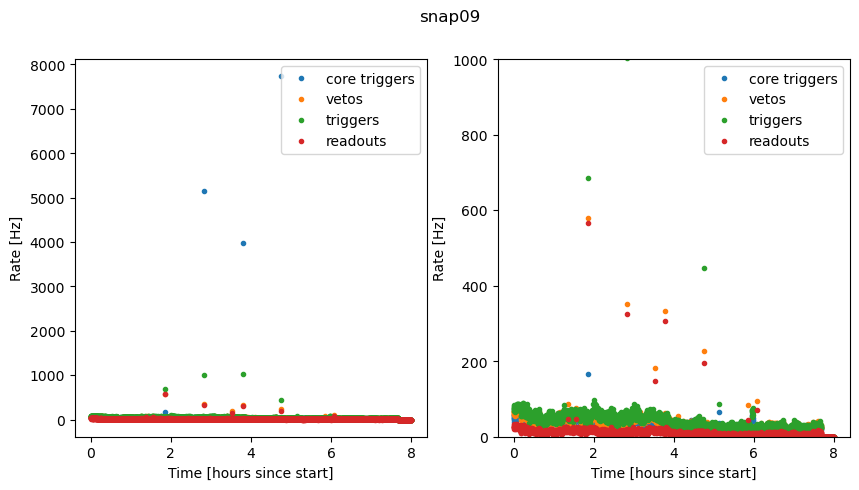

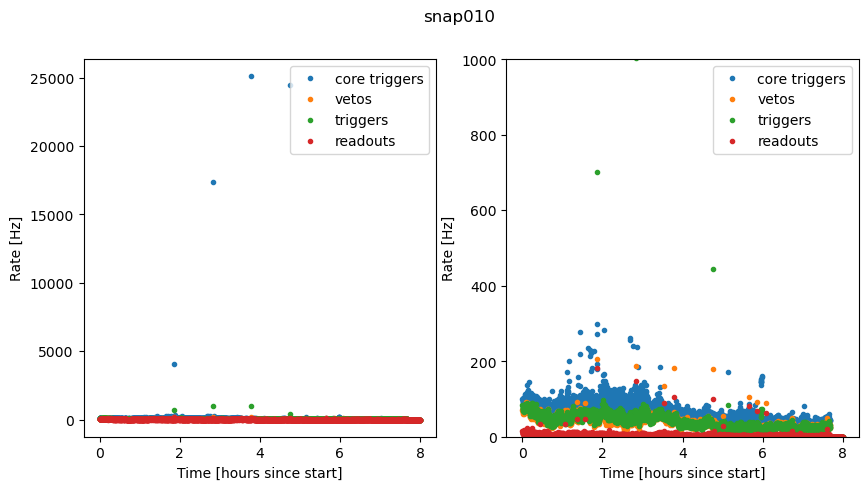

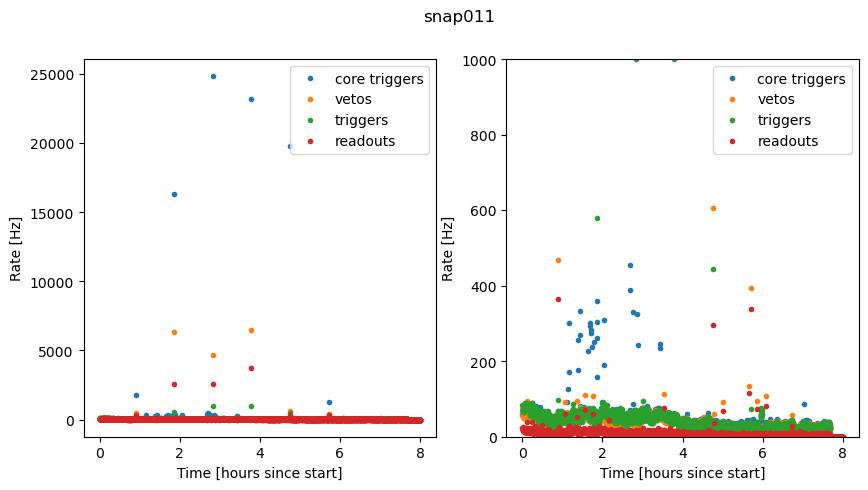

In [197]:
#fname_prefix='/home/ubuntu/kp/data/2023June20/overnight-'
ok_snaps=[2,3,4,5,6,7,8,9,10] #zero indexed

core_all=(np.load(fname_prefix+'core'+'.npy'))*0.73 #convert to Hz
veto_all=(np.load(fname_prefix+'veto'+'.npy'))*0.73 #convert to Hz
#snapshots_all=np.load(fname_prefix+'snapshots_from_packetizer'+'.npy')
internal_trigger_all=(np.load(fname_prefix+'internaltrigger'+'.npy'))*0.73 #convert to Hz
readout_done_all=(np.load(fname_prefix+'readoutdone'+'.npy'))*0.73 #convert to Hz
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    #snapshots=snapshots_all[b]
    internal_trigger=internal_trigger_all[b]
    readout_done=readout_done_all[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.figure(figsize=(10,5),dpi=100)
    plt.suptitle('snap0'+str(b+1))
    
    plt.subplot(121)
    plt.plot(timeaxis,core,'.',label='core triggers')
    plt.plot(timeaxis,veto,'.',label='vetos')
    plt.plot(timeaxis,internal_trigger,'.',label='triggers')
    plt.plot(timeaxis,readout_done,'.',label='readouts')
    #plt.plot(timeaxis,snapshots,'.',label='snapshots')
    plt.ylabel("Rate [Hz]")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    
    plt.subplot(122)
    plt.plot(timeaxis,core,'.',label='core triggers')
    plt.plot(timeaxis,veto,'.',label='vetos')
    plt.plot(timeaxis,internal_trigger,'.',label='triggers')
    plt.plot(timeaxis,readout_done,'.',label='readouts')
    plt.ylim(0,1000)

    #plt.plot(timeaxis,snapshots,'.',label='snapshots')
    plt.ylabel("Rate [Hz]")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    
